# Actual stuff

Launch two terminals from the main tree.

In [1]:
# get some basic os functions
import os
import glob
# import our parallel processing framework
import dask
import dask.multiprocessing
import distributed
# numpy and plotting
import numpy as np
from itertools import accumulate
from operator import matmul
%matplotlib inline
import matplotlib.pyplot as plt
# image reading and writing
from skimage.external import tifffile as tif
#
import seaborn as sns
# load our actual registration functions
from imreg_dph import register_ECC, similarity, translation, register_translation
# monkey patch in numpy's fft, pyfftw doesn't play nice with the cluster
import imreg_dph
imreg_dph.fft2 = np.fft.fft2
imreg_dph.ifft2 = np.fft.ifft2
imreg_dph.fftshift = np.fft.fftshift

if running on the cluster we need to start our scheduler:

    dask-scheduler --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

this should be done on the same computer that's running this notebook (not windows, use login1 or login2 or
 a qlogin interactive session on the cluster)
 
You can now open up a status window [http://[all ip addresses on host]:8787](http://localhost:8787)

In [59]:
# if running on cluster we need to start our workers
!qsub -pe batch 32 -t 1-32 -b y -j y -o ./dask-log.log -cwd -V dask-worker --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

Your job-array 19627818.1-32:1 ("dask-worker") has been submitted


In [3]:
# if running on the cluster we need to attached to the scheduler
client = distributed.Client(scheduler_file="/groups/betzig/home/hoffmand/dask-scheduler.json")

In [5]:
# change this if needed
paths = sorted(glob.iglob("/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_*_InLens/*.tif"))
len(paths)

23749

In [6]:
# generate a list of pairs to register together
pairs = [(paths[i], paths[i + 1]) for i in range(len(paths) - 1)]
pairs[:4]

[('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000030_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000133_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000133_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000237_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000237_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000340_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D

In [7]:
def load_and_register(path0, path1, method=register_translation, *args, **kwargs):
    """Load two images defined by path0 and path1 (assumed to be tif) and register with meth
    
    Parameters
    ----------
    path0 : URI to data0
    path1 : URI to data1
    method : callable
        the registration algortithm
    args : args passed to meth
    kwargs : kwargs passed to meth
    
    Returns
    -------
    af : AffineTransformation
        The affine transformation that registers path1 to path0
    """
    data0 = tif.imread(path0)
    data1 = tif.imread(path1)
    
    return method(data0, data1, *args, **kwargs)

In [11]:
# test the registration and time it
%time af = load_and_register(*pairs[0], register_translation)
print(af)

CPU times: user 14.4 s, sys: 1.55 s, total: 15.9 s
Wall time: 5.82 s
<AffineTransform: translation = [-1.87 -3.35], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [18]:
# as an example let's compute using ecc with translation and rotation
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1) for path0, path1 in pairs])
%time results = to_compute.compute()

CPU times: user 1.84 s, sys: 15.4 ms, total: 1.85 s
Wall time: 1.85 s
CPU times: user 2.27 s, sys: 190 ms, total: 2.46 s
Wall time: 7min 33s


In [19]:
client

<Client: scheduler='tcp://10.36.105.18:8786' processes=33 cores=1040>

In [20]:
results_register_translation = results

In [45]:
# we can save the results in a numpy array
np.save("results_register_translation.npy", np.array([result.params for result in results_register_translation]))

In [23]:
print(af)

<AffineTransform: translation = [-1.87 -3.35], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [33]:
# Now we can propagate the transformations throughout the whole stack.
def plot_af_accum(results):
    results2 = list(accumulate(results, matmul))

    # and plot the results
    fig, axs = plt.subplots(2,2, figsize=(9,9), sharex=True)
    axs = axs.flatten()
    axs[0].plot(np.array([result.translation for result in results2]))
    axs[3].plot(np.rad2deg(np.array([result.rotation for result in results2])))
    axs[1].plot((np.array([result.scale for result in results2])))
    axs[2].plot(np.rad2deg(np.array([result.shear for result in results2])))

    axs[0].set_title("translation")
    axs[3].set_title("rotation")
    axs[1].set_title("scale")
    axs[2].set_title("shear")

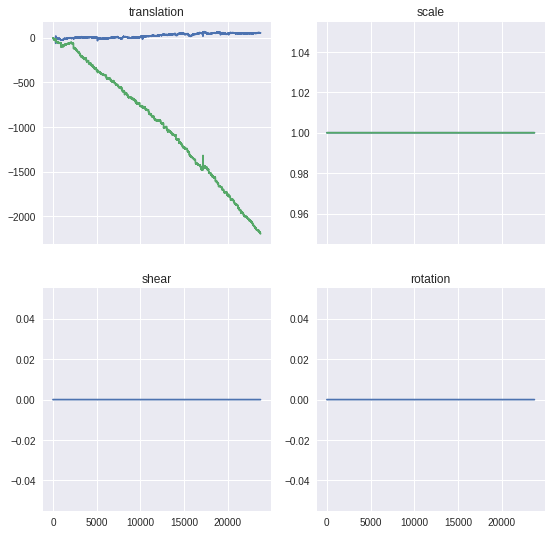

In [50]:
plot_af_accum(results_register_translation)

In [60]:
# test the registration and time it
%time af = load_and_register(*pairs[0], translation)
print(af)

CPU times: user 5.22 s, sys: 1.24 s, total: 6.46 s
Wall time: 6.45 s
<AffineTransform: translation = [-1.93 -3.64], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [72]:
to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, translation)
                           for path0, path1 in pairs])
%time results_translation = to_compute.compute()
plot_af_accum(results_translation)

distributed.utils - ERROR - list-782eca7d-7ef3-4401-9390-66387106e8b5
Traceback (most recent call last):
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 929, in _gather
    st = self.futures[key]
KeyError: 'list-782eca7d-7ef3-4401-9390-66387106e8b5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 193, in f
    result[0] = yield gen.maybe_future(func(*args, **kwargs))
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/to

CancelledError: list-782eca7d-7ef3-4401-9390-66387106e8b5

distributed.client - WARNING - Client report stream closed to scheduler


In [71]:
# we can save the results in a numpy array
np.save("results_translation.npy", np.array([result.params for result in results_translation]))

In [66]:
# test the registration and time it
%time af = load_and_register(*pairs[0], translation)
print(af)

CPU times: user 6.15 s, sys: 14.6 s, total: 20.7 s
Wall time: 20.9 s
<AffineTransform: translation = [-1.93 -3.64], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [67]:
imreg_dph.fft2

<function numpy.fft.fftpack.fft2>

In [70]:
imreg_dph.fft2 = np.fft.fft2
imreg_dph.ifft2 = np.fft.ifft2
imreg_dph.fftshift = np.fft.fftshift
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, similarity) for path0, path1 in pairs[:1000]])
%time results_similarity = to_compute.compute()

CPU times: user 147 ms, sys: 1.61 ms, total: 149 ms
Wall time: 147 ms


distributed.utils - ERROR - ('load_and_register-8f96cfc49253bf726c1e8ff8062eb7c0', 'tcp://10.36.110.40:39713')
Traceback (most recent call last):
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 193, in f
    result[0] = yield gen.maybe_future(func(*args, **kwargs))
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1021, in run
    yielded = self.gen.throw(*exc_info)
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1486, in _get
    result = yield self._gather(packed)
  File "/groups/betzig/home/hoffma

KilledWorker: ('load_and_register-8f96cfc49253bf726c1e8ff8062eb7c0', 'tcp://10.36.110.40:39713')

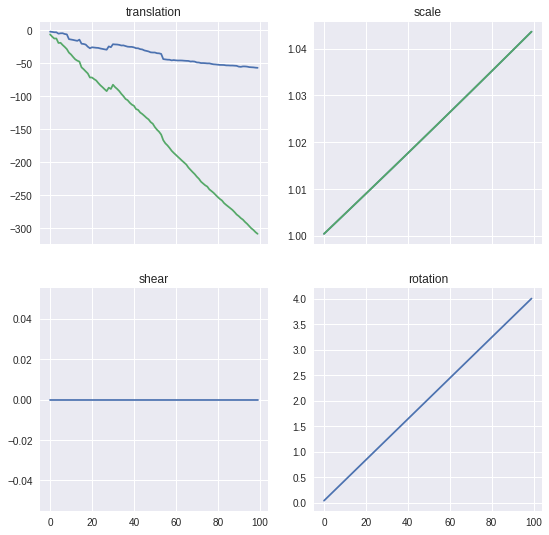

In [69]:
plot_af_accum(results_similarity)

In [39]:
# test the registration and time it
%time af = load_and_register(*pairs[0], register_ECC, warp_mode="euclidean")
print(af)

CPU times: user 1min 27s, sys: 2.9 s, total: 1min 30s
Wall time: 14.1 s
<AffineTransform: translation = [-1.85 -3.66], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [ ]:
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC, warp_mode="translation") for path0, path1 in pairs])
%time results_ecc_trans = to_compute.compute()

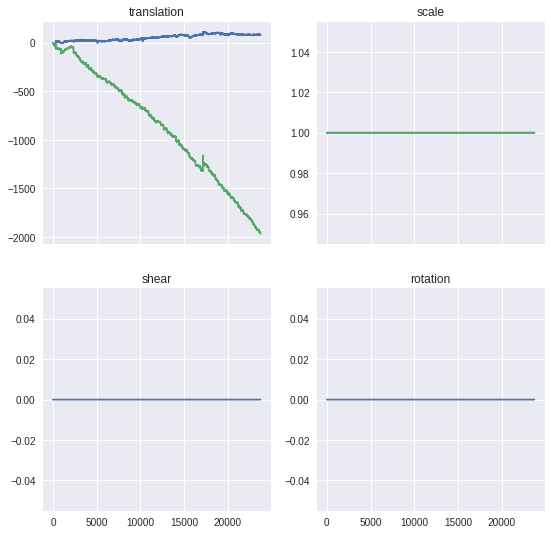

In [52]:
plot_af_accum(results_ecc_trans)

In [46]:
# we can save the results in a numpy array
np.save("results_ecc_trans.npy", np.array([result.params for result in results_ecc_trans]))

In [ ]:
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC, warp_mode="euclidean") for path0, path1 in pairs])
%time results_ecc_euc = to_compute.compute()

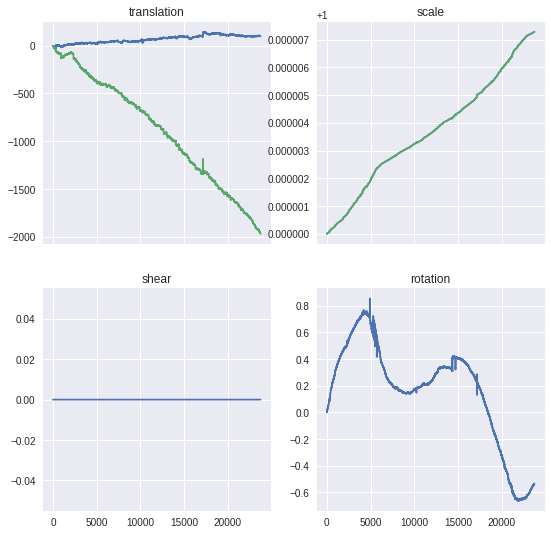

In [53]:
plot_af_accum(results_ecc_euc)

In [47]:
# we can save the results in a numpy array
np.save("results_ecc_euc.npy", np.array([result.params for result in results_ecc_euc]))

In [ ]:
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC, warp_mode="affine") for path0, path1 in pairs])
%time results_ecc_affine = to_compute.compute()

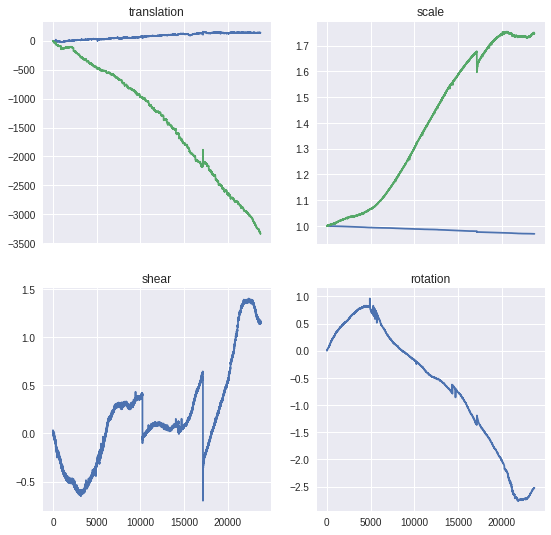

In [54]:
plot_af_accum(results_ecc_affine)

In [48]:
# we can save the results in a numpy array
np.save("results_ecc_affine.npy", np.array([result.params for result in results_ecc_affine]))

In [73]:
!qdel 19627818

hoffmand has registered the job-array task 19627818.1 for deletion
hoffmand has registered the job-array task 19627818.2 for deletion
hoffmand has registered the job-array task 19627818.3 for deletion
hoffmand has registered the job-array task 19627818.4 for deletion
hoffmand has registered the job-array task 19627818.5 for deletion
hoffmand has registered the job-array task 19627818.6 for deletion
hoffmand has registered the job-array task 19627818.7 for deletion
hoffmand has registered the job-array task 19627818.8 for deletion
hoffmand has registered the job-array task 19627818.9 for deletion
hoffmand has registered the job-array task 19627818.10 for deletion
hoffmand has registered the job-array task 19627818.12 for deletion
hoffmand has registered the job-array task 19627818.13 for deletion
hoffmand has registered the job-array task 19627818.14 for deletion
hoffmand has registered the job-array task 19627818.15 for deletion
hoffmand has registered the job-array task 19627818.16 fo

In [74]:
pwd

'/groups/betzig/home/hoffmand/PythonCode/Python Codes'

- apply transforms
- materialization
- apply and bin and materialize